# Second graded assignment: convolutional neural networks

## 1. Imports, Drive mounting, helper function(s)

In [ ]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os
import pickle

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks.experimental import BackupAndRestore

2.4.1


In [ ]:
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')

##!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#helper functions for visualisation

# same function as before - feel free to customize if you want!

def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()


## Loading the data

In the code below, we load the data. The option 'coarse' selects the 20-class version (instead of the 100-class version).

This code is mostly re-used from the first assignment. 

In [ ]:
# Load the data: CIFAR100 with 20 class labels
(x_train_all, r_train_all_class), ( _ , _ ) = cifar100.load_data(label_mode='coarse')

num_classes = 20

val_size = 6000
# make validation set
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size=val_size, random_state=0)

# let's again take a subset of the training data first, for playing around
# Note that such a subset is only useful if it can guide your tuning process,
# i.e., if it leads you to similar decisions as you would make on the whole training set

# You can again use a subset of the training data for initial exploration
# In this case, 10000 samples is really too small, so we suggest 20000

x_train_small = x_train[:20000]
r_train_small_class = r_train_class[:20000]

# And we do the same standardization as in the first assignment
x_train_all = x_train_all.astype('float32')
x_train = x_train.astype('float32')
x_train_small = x_train_small.astype('float32')
x_val = x_val.astype('float32')

x_train_all /= 255.0
x_train /= 255.0
x_train_small /= 255.0
x_val /= 255.0

# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_train_all = tf.keras.utils.to_categorical(r_train_all_class, num_classes)
r_train = tf.keras.utils.to_categorical(r_train_class, num_classes)
r_train_small = tf.keras.utils.to_categorical(r_train_small_class, num_classes)
r_val = tf.keras.utils.to_categorical(r_val_class, num_classes)


# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')



x_train shape: (44000, 32, 32, 3)
44000 train samples
6000 validation samples


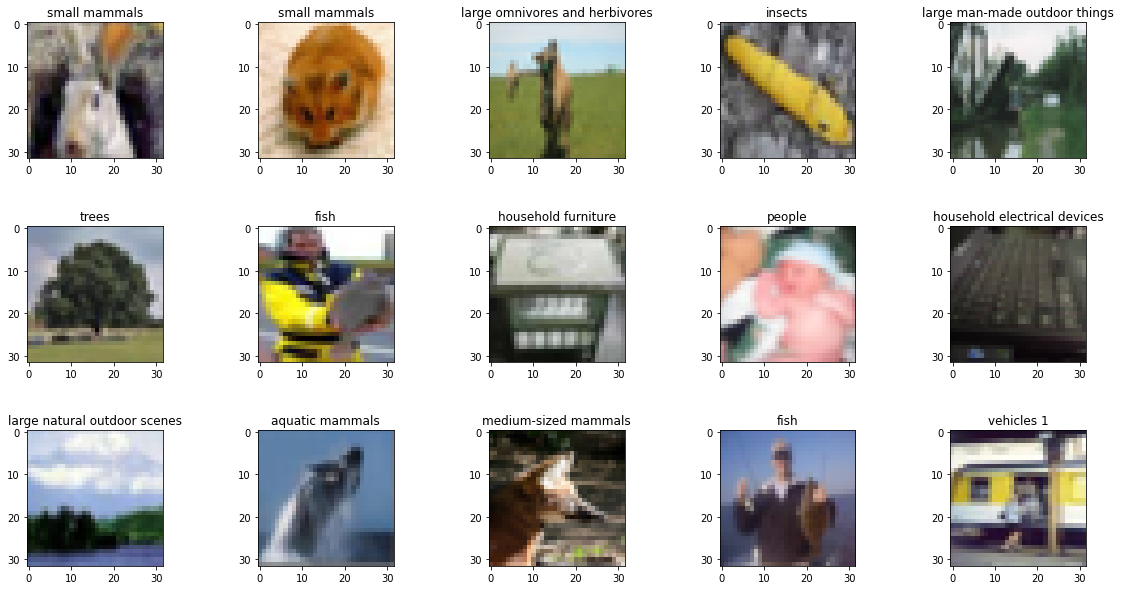

In [ ]:
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title(labels[r_train_class[idx,0]])
    plt.imshow(x_train[idx],  interpolation='None')

# The model

In [ ]:
'''Train a simple CNN on the CIFAR100 small images dataset.
Initial model based on example networks used for CIFAR10
e.g., https://keras.io/examples/cifar10_cnn/
'''

# Recall the two main structural paramameters of a network: layer width and network depth
#
# - Layer width determines how many "different things" can be extracted by a layer. 
# - depth determines the complexity of the features that can be extracted

# In convnets, layers are often organised in blocks of layers with the same width, 
# followed by a pooling step to reduce the layer size
# This again allows more complex features to be extracted between pooling steps 

# The first conv layers have 32 filters (channels) with filter size 3x3
# note that this has no relation with the image size, which just happens to be 32x32 pixels!

def initial_model():   

  model = Sequential()

  model.add(Conv2D(256, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))
  
  model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(1024, kernel_size=(3, 3), padding='same'))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))  
  model.add(Conv2D(1024, kernel_size=(3, 3), padding='same', kernel_constraint=tf.keras.constraints.MaxNorm()))  
  model.add(BatchNormalization())  
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(GlobalMaxPooling2D())

  model.add(Flatten())  
  model.add(Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
  model.add(Activation('relu'))  
  model.add(Dense(num_classes))  
  model.add(Activation('softmax'))  

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)  

  model.compile(loss='categorical_crossentropy',  
  optimizer=opt,  
  metrics=['accuracy'])  

  return model

## Training the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0

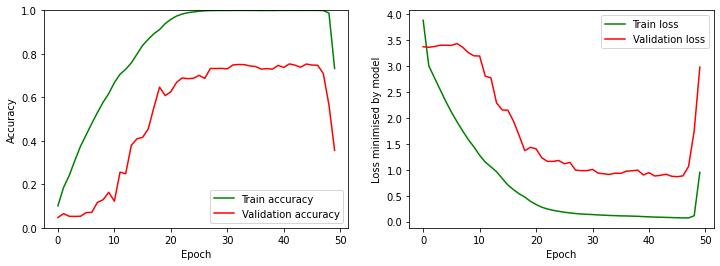

In [ ]:
# checkpoint and early stopping code from first assignment is introduced in comments:
# use or replace by your preferred workflow 
# do not forget to reload best model for evaluation after using early stopping (re-use code from first assignment)


class HistoryCheckpoint(History):
  def __init__(self, pickle_path, monitor):
    """
    A custom callback that saves the training history to a pickle file after
    every epoch.
    Arguments:
      pickle_path: the path of where the history should be stored.
      monitor: the value that indicates what the 'best' model is.
    """
    super().__init__()
    self.pickle_path = pickle_path
    self.monitor = monitor
    self.is_resuming = False

  def load_history(self):
    """
    Try to open the history file at the given pickle_path.
    """
    with open(self.pickle_path, "rb") as file:
      self.history = pickle.load(file)
      self.epoch = [i for i in range(len(self.history['loss']))]
      self.is_resuming = True
      

  def on_train_begin(self, logs=None):
    # If not already resuming from a loaded history, then initialize all
    # fields using the code from the History callback.
    if not self.is_resuming:
      super().on_train_begin(logs)

  def on_epoch_end(self, epoch, logs=None):
    # Update the history according to the functionality of History.
    super().on_epoch_end(epoch, logs)

    # Save the history to a pickle file.
    with open(self.pickle_path, "wb") as file:
      pickle.dump(self.history, file)

  def on_train_end(self, logs=None):
    os.remove(self.pickle_path)

batch_size = 1024
epochs = 50


monitor = 'val_accuracy'
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/Initial/"
# Create a callback that saves the latest model.
backup_callback = BackupAndRestore(checkpoint_dir + "backup/")
# Create a callback that saves the best model so far.
best_model_savename = checkpoint_dir+"best_model.h5"
best_cp_callback = ModelCheckpoint(best_model_savename,
                                   monitor=monitor,
                                   save_weights_only=False,
                                   save_best_only=True,
                                   verbose=1)
# callback for saving checkpoints
model_savename = checkpoint_dir+"initial_model_v1.h5"
checkpoint_path = checkpoint_dir+"checkpoints/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 monitor='val_accuracy',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Intitialize a HistoryCheckpoint.
history_callback = HistoryCheckpoint(checkpoint_dir + "history.pi", 
                                     monitor=monitor)




model_1 = initial_model()
model_1.summary()

# code for modelcheckpoint and early stopping  commented below
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,min_delta=0.0001)
try:
  # Try to resume from a history.
  history_callback.load_history()

  # Set the best value from this history in the 'best model' callback.
  if best_cp_callback.monitor_op == np.less:
    best_cp_callback.best = np.min(history_callback.history[monitor])
  if best_cp_callback.monitor_op == np.greater:
    best_cp_callback.best = np.max(history_callback.history[monitor])
  print(f"History with {len(history_callback.epoch)} epochs loaded!")
except OSError:
  print("No history found, starting new logs!")

model_1.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, r_val),
          callbacks=[history_callback, backup_callback, stopping_callback, best_cp_callback, cp_callback],
          #callbacks=[history_callback, backup_callback, best_cp_callback, cp_callback],
          shuffle=True)
history_1 = history_callback

# Run code below to save the weights of final trained model:
# (not very useful in combination with modelcheckpoint, because then you would revert to the best model afterwards)
model_1.save_weights(model_savename)

# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

In [ ]:
import pathlib

# Find latest checkpoint
# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir+"checkpoints/").glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
print(latest)


# You can later reconstruct this model by first rebuilding a model with the same structure 
# (so make sure you keep the code for that)
# and then loading the weights:

reconstructed_model_1 = initial_model() # this is a new model
reconstructed_model_1.load_weights(model_savename)

# The code below should give the same results as that for the original model
[train_loss, train_accuracy] = reconstructed_model_1.evaluate(x_train, r_train, verbose=0)
print("Training set Accuracy:{:7.4f}".format(train_accuracy))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_accuracy] = reconstructed_model_1.evaluate(x_val, r_val, verbose=0)
print("Validation set Accuracy:{:7.4f}".format(val_accuracy))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/Initial/checkpoints/cp-0042.ckpt
Training set Accuracy: 0.4069
Training set Loss:2.506191

Validation set Accuracy: 0.3563
Validation set Loss:2.975133



In [ ]:
# Normally, the backup is deleted automatically after all training epochs have ended. 
# Executing this command forces the deletion even if the training is not done yet.
!rm -r "{checkpoint_dir + "backup/"}"
#!rm -r "{checkpoint_dir + "checkpoints/"}"

# Again, the history will be removed after a full training run automatically,
# but you can force the history to be deleted to be sure:
!rm -r "{checkpoint_dir + "history.pi"}"

rm: cannot remove '/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/Initial/history.pi': No such file or directory


## Retrain on all data before augmentation


In [ ]:
model_for_test = initial_model()
model_1.summary()

# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 1024
epochs = 45

history_for_test = model_for_test.fit(x_train_all, r_train_all,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1
                    )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0

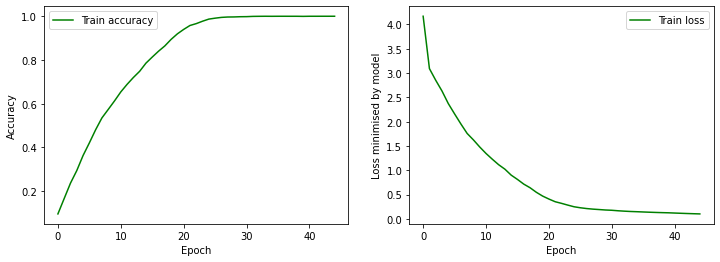

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['accuracy']),'g-',
        label='Train accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss minimised by model')
plt.plot(history_for_test.epoch, np.array(history_for_test.history['loss']),'g-',
        label='Train loss')
plt.legend()

In [ ]:
#the file type for storing complete models is ".h5"
# feel free to change the path to whatever suits you best!
modelpath = checkpoint_dir+"final_model_without_augmentation.h5"

print("Final model saved as ",modelpath)

# Save entire model to a HDF5 file
model_for_test.save(modelpath)

Final model saved as  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/Initial/final_model_without_augmentation.h5


## 3. Augmentation

When using data augmentation on large data sets, it is not feasible to generate the augmented samples up-front. Instead, they are generated 'on the fly' when reading in batches: before each training sample is used in a batch, it is first augmented, so each time the same original sample is used, its augmented version is different. This is done using an ImageDataGenerator.

Before actually using augmentation, it is usually a good idea to have a look at some augmented images. The code block below shows how you can do this.

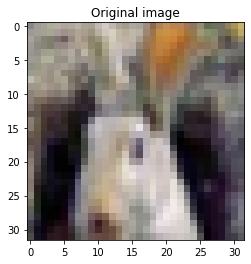

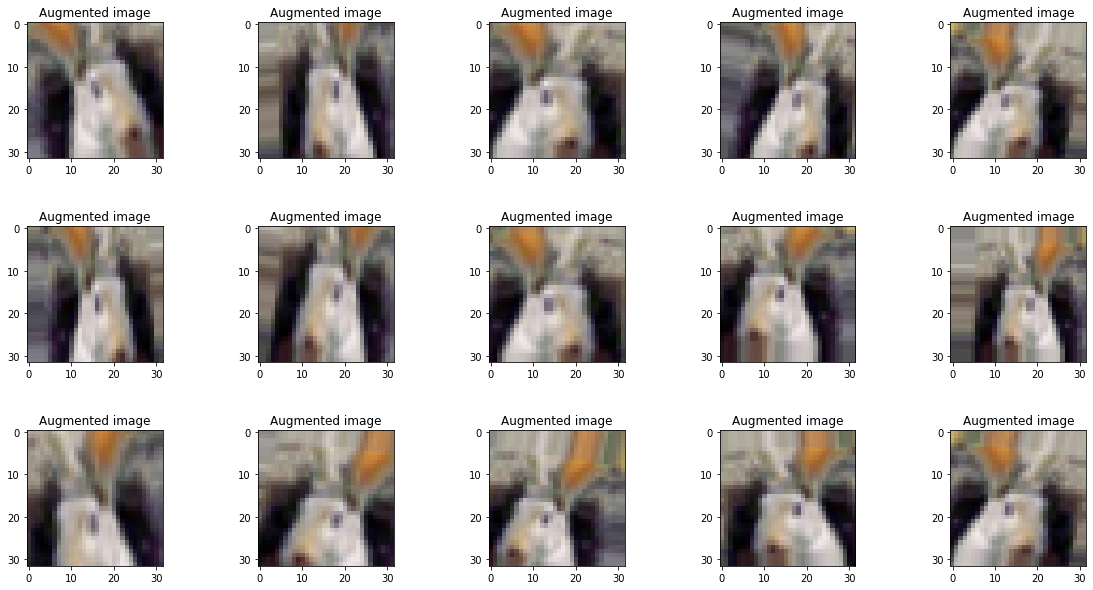

In [ ]:
# An object from the class ImageDataGenerator will do 'on-the-fly' data augmentation
# every time you call its function .flow()

# Note that not all options are used here: check the docs for additional info
# the class also contains a 'hook' for adding your own augmentation functions

datagen = ImageDataGenerator(
        rotation_range=15.0,  # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode = 'nearest', # what to do with 'new' pixels that occur as the result of a transformation
        zoom_range = 0.25)  

# select and show an image from the training set
img_index = 0

plt.figure()
plt.imshow(x_train[img_index],  interpolation='None')
plt.title("Original image")
plt.show()

testit = datagen.flow(x_train[img_index:img_index+1], batch_size=1)

# generate 15 augmented images (the first one is the original image)
f = plt.figure(figsize=(20,10))
for idx in range(15):
    plt.subplot(3,5,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Augmented image")
    plt.imshow(testit.next()[0,:,:,:],  interpolation='None')
plt.show()



In [ ]:
batch_size = 1024
epochs = 120

au_model = initial_model()
au_model.summary()
au_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# dummy file path here ... this is local on Colab!
filepath = checkpoint_dir+"intermediate_model_with_augmentation.h5"

callbacks = [EarlyStopping(monitor='val_accuracy', patience=30),
             ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)]

datagen = ImageDataGenerator(
        rotation_range=15.0,  # randomly rotate images in the range (degrees, 0 to 180) - note that rotation is more compute-intensive than shifting!!
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode = 'nearest', # what to do with 'new' pixels that occur as the result of a transformation
        zoom_range = 0.25)  

# Compute quantities required for some augmentation functions
# (e.g., std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train, augment=True)

# Fit the model on the batches generated by datagen.flow().
au_history = au_model.fit(datagen.flow(x_train, r_train, batch_size=batch_size),
                                    epochs=epochs, steps_per_epoch=len(x_train) / batch_size,
                                    validation_data=(x_val, r_val),
                                    callbacks = callbacks)



# Note: you can totally ignore the warning you get:
# WARNING:tensorflow:sample_weight modes were coerced from ... to ['...']
# this appears to be a bug in tf 2.1


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_48 (Activation)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_49 (Activation)   (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 256)      

By running the code below, you can compare the situation with and without augmentation (or any two situations ...). 

In this case, we can conclude that augmentation managed to reduced most of the overfitting, but it did not fundamentally improve validation accuracy. The main reason for this is probably that the network is nowhere close to decent yet: remember that **augmentation can help reduce overfitting**. However, this can only improve validation accuracy if the model has low enough bias. In this case, bias is still way too high!

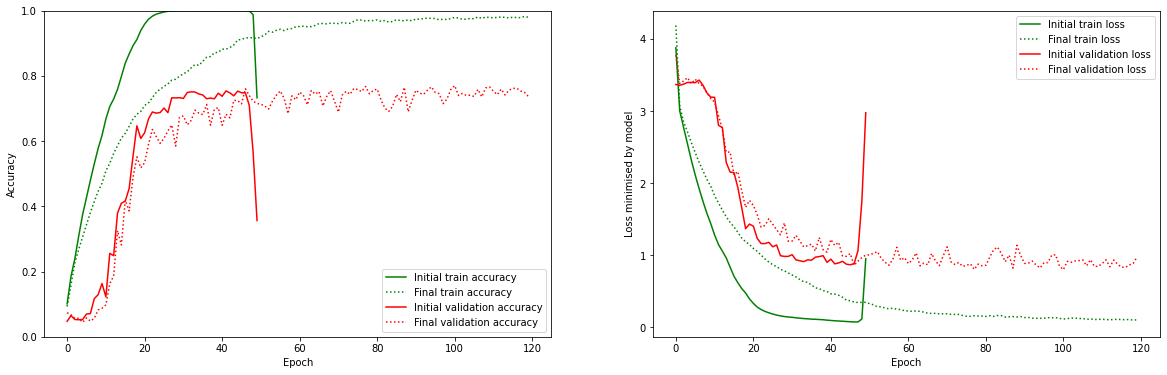

In [ ]:
def plot_dual_history(before,after):
  plt.figure(figsize = (20,6))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(before.epoch, np.array(before.history['accuracy']),'g-',
           label='Initial train accuracy')
  plt.plot(after.epoch, np.array(after.history['accuracy']),'g:',
           label='Final train accuracy')
  plt.plot(before.epoch, np.array(before.history['val_accuracy']),'r-',
           label = 'Initial validation accuracy')
  plt.plot(after.epoch, np.array(after.history['val_accuracy']),'r:',
           label = 'Final validation accuracy')
  plt.ylim([0.0,1.0])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(before.epoch, np.array(before.history['loss']),'g-',
           label='Initial train loss')
  plt.plot(after.epoch, np.array(after.history['loss']),'g:',
           label='Final train loss')
  plt.plot(before.epoch, np.array(before.history['val_loss']),'r-',
           label = 'Initial validation loss')
  plt.plot(after.epoch, np.array(after.history['val_loss']),'r:',
           label = 'Final validation loss')
  plt.legend()


plot_dual_history(history_1,au_history)
